In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression,Perceptron
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,f1_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

2023-06-10 19:02:36.742854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
import shap

## 1.Import Data & Explorative Analysis

In [8]:
train0 = pd.read_excel(io='./QWE_training_data.xlsx')
test0 = pd.read_excel(io='./QWE_test_data.xlsx')
train = train0.iloc[:,2:]
test = test0.iloc[:,2:]
train_raw = train

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5077 entries, 0 to 5076
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer_Age_inmonths  5077 non-null   int64  
 1   Churn                  5077 non-null   int64  
 2   CHI_M0                 5077 non-null   int64  
 3   CHI_M01                5077 non-null   int64  
 4   Support_M0             5077 non-null   int64  
 5   Support_M01            5077 non-null   int64  
 6   SP_M0                  5077 non-null   float64
 7   SP_M01                 5077 non-null   float64
 8   Logins_M01             5077 non-null   int64  
 9   Blog_M01               5077 non-null   int64  
 10  Views_M01              5077 non-null   int64  
 11  DaysLastLogin_M01      5077 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 476.1 KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer_Age_inmonths  1270 non-null   int64  
 1   Churn                  1270 non-null   int64  
 2   CHI_M0                 1270 non-null   int64  
 3   CHI_M01                1270 non-null   int64  
 4   Support_M0             1270 non-null   int64  
 5   Support_M01            1270 non-null   int64  
 6   SP_M0                  1270 non-null   float64
 7   SP_M01                 1270 non-null   float64
 8   Logins_M01             1270 non-null   int64  
 9   Blog_M01               1270 non-null   int64  
 10  Views_M01              1270 non-null   int64  
 11  DaysLastLogin_M01      1270 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 119.2 KB


In [9]:
print(train.isna().sum())
test.isna().sum()

Customer_Age_inmonths    0
Churn                    0
CHI_M0                   0
CHI_M01                  0
Support_M0               0
Support_M01              0
SP_M0                    0
SP_M01                   0
Logins_M01               0
Blog_M01                 0
Views_M01                0
DaysLastLogin_M01        0
dtype: int64


Customer_Age_inmonths    0
Churn                    0
CHI_M0                   0
CHI_M01                  0
Support_M0               0
Support_M01              0
SP_M0                    0
SP_M01                   0
Logins_M01               0
Blog_M01                 0
Views_M01                0
DaysLastLogin_M01        0
dtype: int64

In [11]:
lost = train.loc[train['Churn']==1]
own = train.loc[train['Churn']==0]

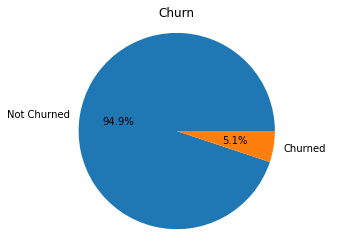

In [12]:
churn_counts = train['Churn'].value_counts()

labels = ['Not Churned', 'Churned']
counts = churn_counts.values

plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  
plt.title('Churn')
plt.show()

In [13]:
print(lost.iloc[:,1:].describe())

       Churn      CHI_M0     CHI_M01  Support_M0  Support_M01       SP_M0  \
count  260.0  260.000000  260.000000  260.000000   260.000000  260.000000   
mean     1.0   63.576923   -3.823077    0.384615     0.030769    0.505220   
std      0.0   57.428265   29.211508    1.110738     1.308944    1.115093   
min      1.0    0.000000 -105.000000    0.000000    -8.000000    0.000000   
25%      1.0    7.500000  -16.000000    0.000000     0.000000    0.000000   
50%      1.0   56.500000    0.000000    0.000000     0.000000    0.000000   
75%      1.0  105.250000    7.000000    0.000000     0.000000    0.000000   
max      1.0  231.000000   73.000000   10.000000     9.000000    4.000000   

           SP_M01  Logins_M01    Blog_M01     Views_M01  DaysLastLogin_M01  
count  260.000000  260.000000  260.000000    260.000000         260.000000  
mean    -0.028434    8.834615   -0.092308   -123.880769           6.465385  
std      1.372120   42.585362    1.529358   1939.285407          21.387100 

### 相关性分析

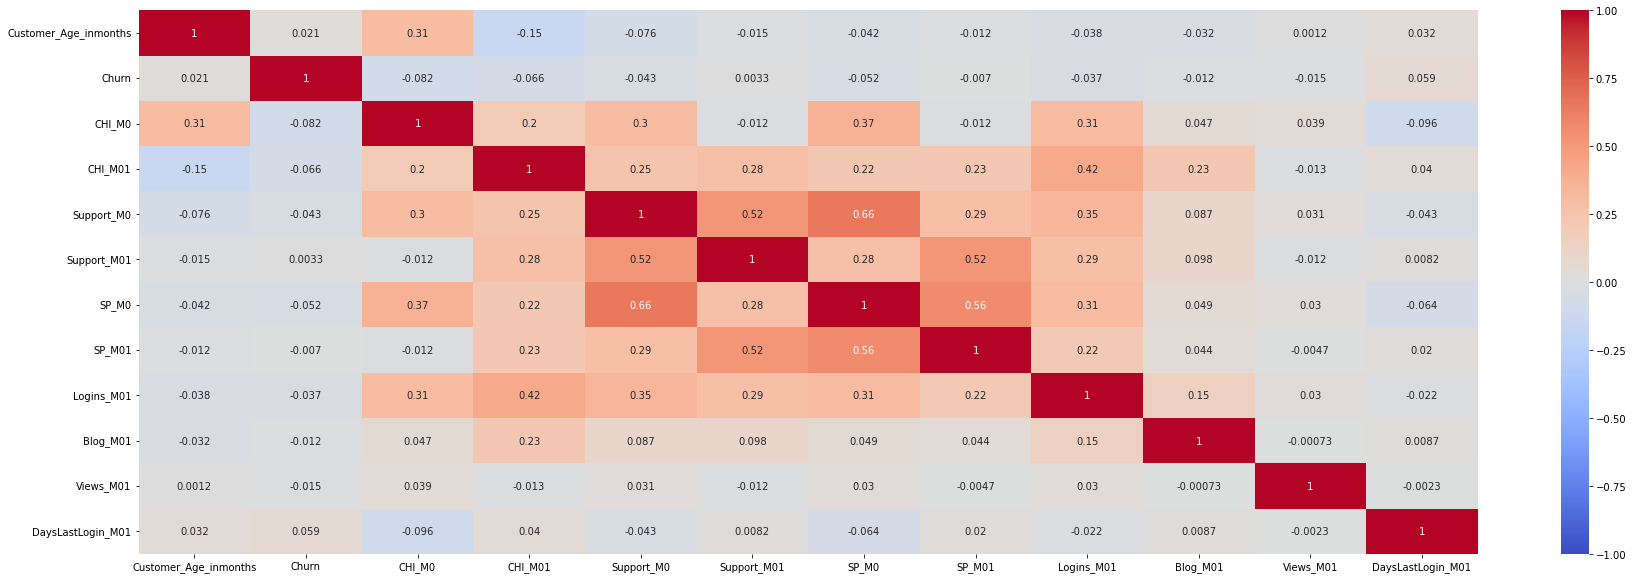

In [14]:
corr = train.corr()
plt.figure(figsize=(30, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm',vmin=-1, vmax=1)
plt.show()

### 画箱线图初步观察分布并识别删除异常值

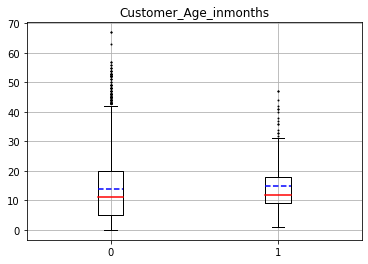

In [15]:
labels = '0','1'
plt.grid(True)
plt.boxplot([own['Customer_Age_inmonths'],lost['Customer_Age_inmonths']],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 1},
            labels=labels)
plt.title('Customer_Age_inmonths')
plt.show()


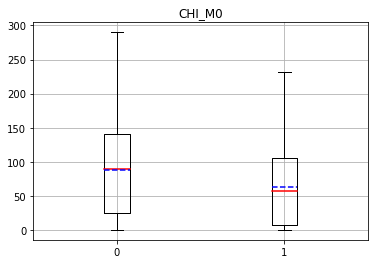

In [16]:
labels = '0','1'
plt.grid(True)
plt.boxplot([own['CHI_M0'],lost['CHI_M0']],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 1},
            labels=labels)
plt.title('CHI_M0')
plt.show()


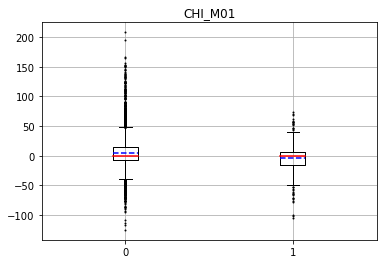

In [17]:
labels = '0','1'
plt.grid(True)
plt.boxplot([own['CHI_M01'],lost['CHI_M01']],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 1},
            labels=labels)
plt.title('CHI_M01')
plt.show()

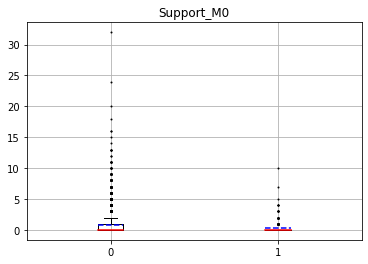

In [18]:
labels = '0','1'
plt.grid(True)
plt.boxplot([own['Support_M0'],lost['Support_M0']],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 1},
            labels=labels)
plt.title('Support_M0')
plt.show()

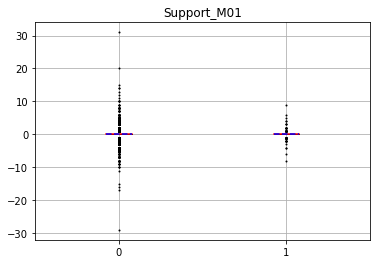

In [19]:
labels = '0','1'
plt.grid(True)
plt.boxplot([own['Support_M01'],lost['Support_M01']],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 1},
            labels=labels)
plt.title('Support_M01')
plt.show()

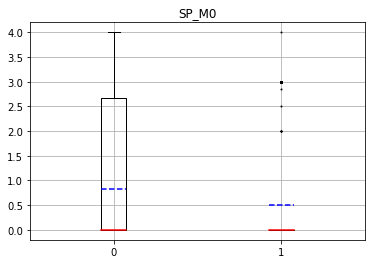

In [20]:
labels = '0','1'
plt.grid(True)
plt.boxplot([own['SP_M0'],lost['SP_M0']],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 1},
            labels=labels)
plt.title('SP_M0')

plt.show()

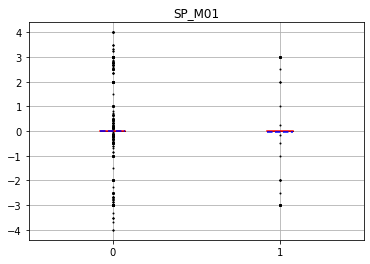

In [21]:
labels = '0','1'
plt.grid(True)
plt.boxplot([own['SP_M01'],lost['SP_M01']],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 1},
            labels=labels)
plt.title('SP_M01')
plt.show()

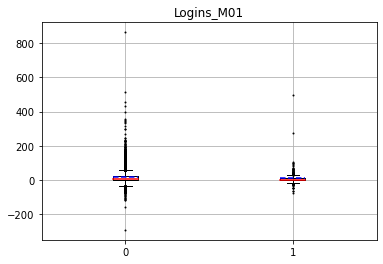

In [22]:
labels = '0','1'
plt.grid(True)
plt.boxplot([own['Logins_M01'],lost['Logins_M01']],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 1},
            labels=labels)
plt.title('Logins_M01')
plt.show()

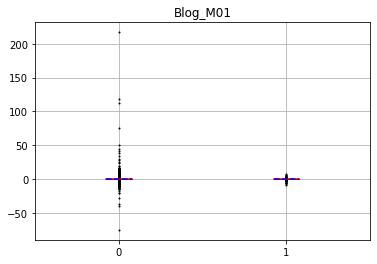

In [23]:
labels = '0','1'
plt.grid(True)
plt.boxplot([own['Blog_M01'],lost['Blog_M01']],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 1},
            labels=labels)
plt.title('Blog_M01')
plt.show()

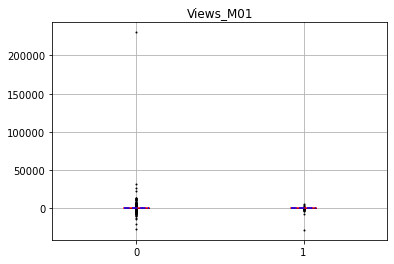

In [24]:
labels = '0','1'
plt.grid(True)
plt.boxplot([own['Views_M01'],lost['Views_M01']],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 1},
            labels=labels)
plt.title('Views_M01')
plt.show()

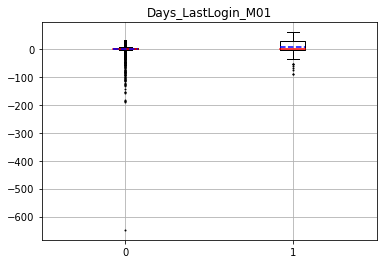

In [25]:
labels = '0','1'
plt.grid(True)
plt.boxplot([own['DaysLastLogin_M01'],lost['DaysLastLogin_M01']],
            medianprops={'color': 'red', 'linewidth': '1.5'},
            meanline=True,
            showmeans=True,
            meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 1},
            labels=labels)
plt.title('Days_LastLogin_M01')
plt.show()

In [75]:
##对Logins进行清洗
train.drop(index=train.loc[(train['Churn'] == 0) & (train['Logins_M01'] > 800)].index, inplace=True)
train.drop(index=train.loc[(train['Churn'] == 1) & (train['Logins_M01'] > 200)].index, inplace=True)
##对Blogs进行清洗
train.drop(index=train.loc[(train['Churn'] == 0) & (train['Blog_M01'] > 200)].index, inplace=True)
#删除views异常值
train.drop(index=train.loc[(train['Churn'] == 0) & (train['Views_M01'] > 200000)].index, inplace=True)
#删除dayslastlogin异常值
train.drop(index=train.loc[(train['Churn'] == 0) & (train['DaysLastLogin_M01'] > 200000)].index, inplace=True)

### 清洗之后，再进行分布的可视化

In [27]:
lost = train.loc[train['Churn']==1]
own = train.loc[train['Churn']==0]

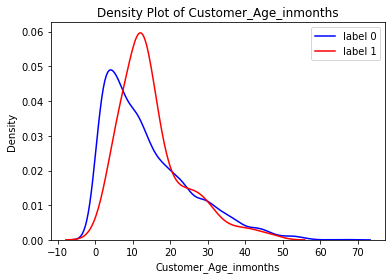

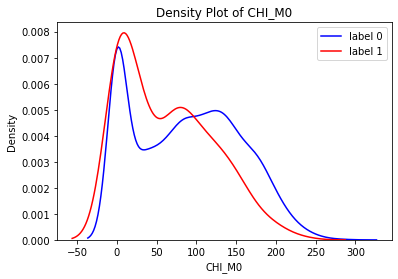

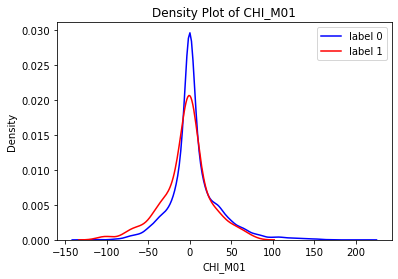

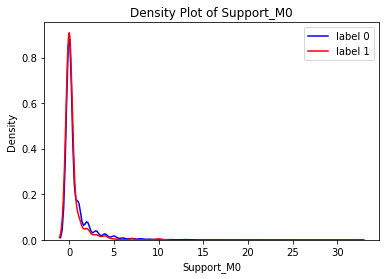

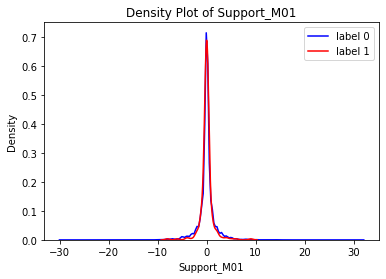

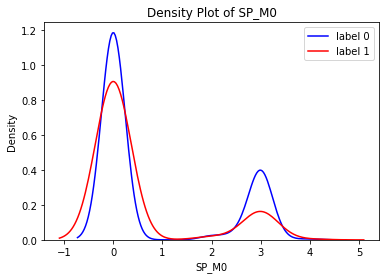

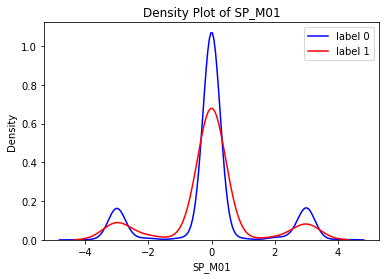

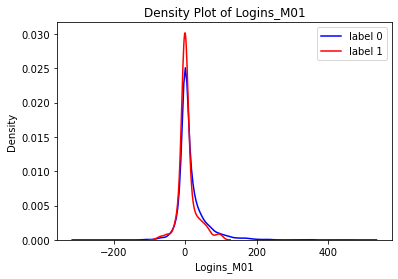

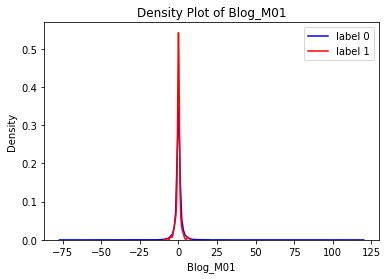

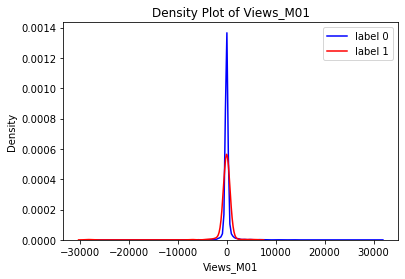

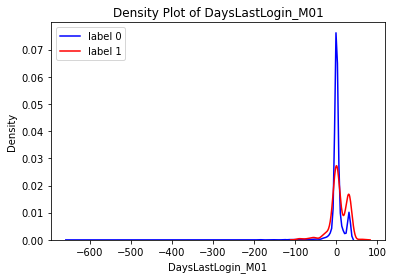

In [28]:
for column in train.columns:
    if column == 'Churn':
        continue
    # 绘制own数据集的密度曲线
    sns.kdeplot(own[column], label='label 0', color='blue')
    # 绘制lost数据集的密度曲线
    sns.kdeplot(lost[column], label='label 1', color='red')
    plt.title(f"Density Plot of {column}")
    
    plt.legend()
    plt.show()

## 降维分析

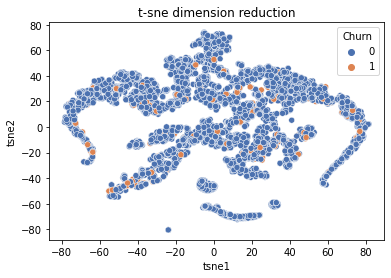

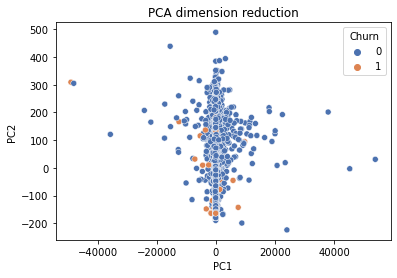

In [486]:

X_train = train.drop('Churn', axis=1)
y_train = train['Churn']

ebd = TSNE(n_components=2)
data_tsne = ebd.fit_transform(X_train)
data = train
data['tsne1'] = data_tsne[:,0]
data['tsne2'] = data_tsne[:,1]
sns.scatterplot(data=data,x='tsne1',y='tsne2',hue='Churn',palette='deep')
plt.title('t-sne dimension reduction')
plt.show()


pca_data = PCA(2).fit_transform(X_train)
df=train
df['PC1']=pca_data[:,0]
df['PC2']=pca_data[:,1]
sns.scatterplot(data=df,x='PC1',y='PC2',hue='Churn',palette='deep')
plt.title('PCA dimension reduction')
plt.show()

### preprocessing:SMOTE
#### 样本量本身不大，采用重采样比欠采样更合理；SMOTE算法的基本思想是对于少数类样本中的每个样本，随机选择若干个最近邻样本，然后在样本与其最近邻样本之间进行插值，生成新的合成样本。这些合成样本被添加到原始数据集中，从而增加了少数类样本的数量。然而，这并不是我的方法中最合理的处理方式，因为我的目标是建立一个可通过调参达到不同accuracy和recall的模型，而通过smote无法做到，只能作为baseline参考

In [484]:
X_train = train.drop('Churn', axis=1)
y_train = train['Churn']
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
train_smote = pd.concat([X_train_smote, y_train_smote], axis=1)

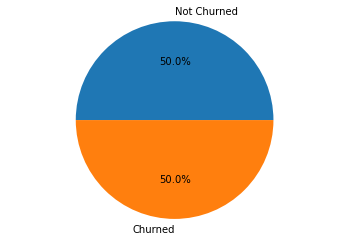

In [65]:
churn_counts = train_smote['Churn'].value_counts()

labels = ['Not Churned', 'Churned']
counts = churn_counts.values

plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  
plt.show()

## Logistic Regression Model(sklearn)

In [29]:
train0 = pd.read_excel(io='./QWE_training_data.xlsx')
test0 = pd.read_excel(io='./QWE_test_data.xlsx')
train = train0.iloc[:,2:]
test = test0.iloc[:,2:]

In [81]:
##初始化训练数据
X_train = train.drop(['Churn'],axis=1)
y_train = train['Churn']
X_test = test.drop(['Churn'],axis=1)
y_test = test['Churn']

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [100]:
model1=LogisticRegression()
model1.fit(X_train_std,y_train)


LogisticRegression()

In [101]:
print('overall accuracy:',model1.score(X_test_std,y_test))

overall accuracy: 0.9503937007874016


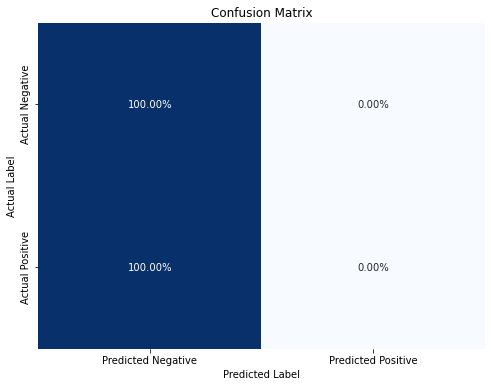

                 Predicted Negative  Predicted Positive
Actual Negative                1207                   0
Actual Positive                  63                   0
Precision: 0 recall: 0.0


In [103]:
y_pred = model1.predict(X_test_std)

cm = confusion_matrix(y_test, y_pred)
class_totals = cm.sum(axis=1, keepdims=True)


normalized_cm = cm / class_totals


df_confusion_matrix = pd.DataFrame(normalized_cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='.2%', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
df_cm = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'], columns=['Predicted Negative','Predicted Positive'])
print(df_cm)


df_cm['Precision'] = ''
df_cm.loc['Recall'] = ''

# 计算精确度和召回率
true_positive = df_cm.at['Actual Positive', 'Predicted Positive']
false_positive = df_cm.at['Actual Negative', 'Predicted Positive']
false_negative = df_cm.at['Actual Positive', 'Predicted Negative']

precision = 0
recall = true_positive / (true_positive + false_negative)

print('Precision:',precision,'recall:',recall)


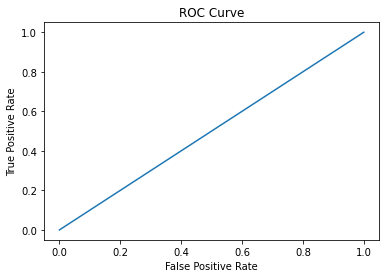

AUC= 0.5
F1-score: 0.0


In [107]:
##画出ROC曲线
y_pred_1 = model1.predict(X_test_std)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
#计算AUC

auc = roc_auc_score(y_test, y_pred_1)
print('AUC=',auc)

In [76]:
## smote后的数据进行回归
X_train = train_smote[['Customer_Age_inmonths','CHI_M0','CHI_M01','Support_M0','Support_M01','DaysLastLogin_M01']]
y_train = train_smote['Churn']
X_test = test[['Customer_Age_inmonths','CHI_M0','CHI_M01','Support_M0','Support_M01','DaysLastLogin_M01']]
y_test = test['Churn']

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
model10=LogisticRegression()
model10.fit(X_train_std,y_train)
print('overall accuracy:',model10.score(X_test_std,y_test))
y_pred_10 = model10.predict(X_test_std)
auc = roc_auc_score(y_test, y_pred_10)
print('AUC=',auc)


overall accuracy: 0.5755905511811024
AUC= 0.611229468313147


### 加权改善underrepresented类的表现

In [52]:
weights = {0:1,1:14.5}
model2 =LogisticRegression(class_weight=weights)
model2.fit(X_train_std,y_train)
y_pred_2 = model2.predict(X_test_std)
print('overall accuracy:',model2.score(X_test_std,y_test))

overall accuracy: 0.8


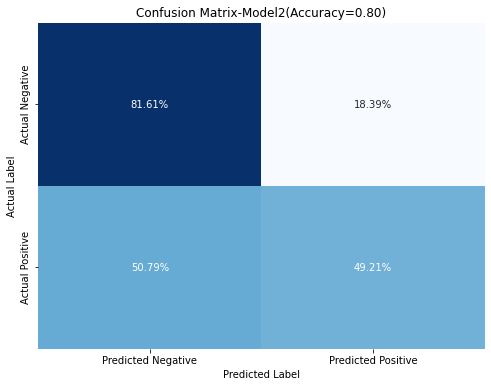

                 Predicted Negative  Predicted Positive
Actual Negative                 985                 222
Actual Positive                  32                  31
Precision: 0.1225296442687747 recall: 0.49206349206349204


In [53]:
cm = confusion_matrix(y_test, y_pred_2)
class_totals = cm.sum(axis=1, keepdims=True)


normalized_cm = cm / class_totals


df_confusion_matrix = pd.DataFrame(normalized_cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='.2%', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix-Model2(Accuracy={:.2f})'.format(model2.score(X_test_std,y_test)))
plt.show()
df_cm = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'], columns=['Predicted Negative','Predicted Positive'])
print(df_cm)

true_positive = df_cm.at['Actual Positive', 'Predicted Positive']
false_positive = df_cm.at['Actual Negative', 'Predicted Positive']
false_negative = df_cm.at['Actual Positive', 'Predicted Negative']

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print('Precision:',precision,'recall:',recall)

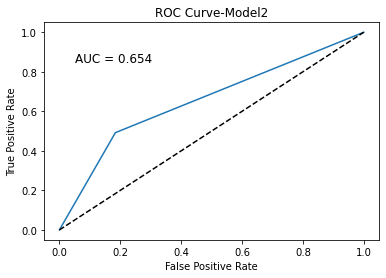

auc: 0.6540682000499731


In [54]:
##画出ROC曲线
auc_model2 = roc_auc_score(y_test, y_pred_2)
y_scores_2 = model2.decision_function(X_test_std)
y_true_binary = label_binarize(y_test, classes=[0, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_2)
plt.plot(fpr, tpr,label='AUC = {:.2f}'.format(auc_model2))
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.text(0.05, 0.9, 'AUC = {:.3f}'.format(auc_model2), fontsize=12,va='top')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-Model2')

plt.show()
print('auc:',auc_model2)


In [55]:
features = X_train.columns
coefficients = model2.coef_
intercept = model2.intercept_
for feature, coef in zip(features, coefficients[0]):
    print(f"Feature: {feature}, Coefficient: {coef}")

Feature: Customer_Age_inmonths, Coefficient: 0.14396059469913933
Feature: CHI_M0, Coefficient: -0.30358249110542884
Feature: CHI_M01, Coefficient: -0.29764724487543937
Feature: Support_M0, Coefficient: -0.2021359058171028
Feature: Support_M01, Coefficient: 0.2128855899931115
Feature: SP_M0, Coefficient: -0.035753664739327305
Feature: SP_M01, Coefficient: -0.01171012927907328
Feature: Logins_M01, Coefficient: 0.04459805868722814
Feature: Blog_M01, Coefficient: 0.006388723967577608
Feature: Views_M01, Coefficient: -0.3838993588598867
Feature: DaysLastLogin_M01, Coefficient: 0.23866044481484025


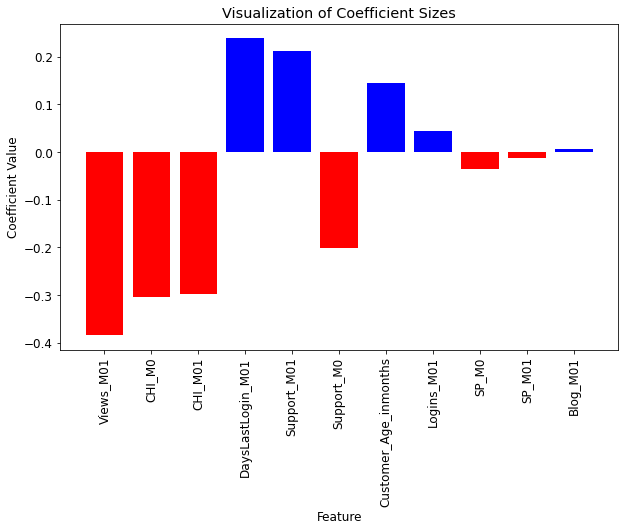

In [73]:
coefficients = model2.coef_[0]
features_names = list(features)
abs_coefficients = np.abs(coefficients)

coefficients_list = list(zip(feature_names, coefficients, abs_coefficients))

sorted_coefficients = sorted(coefficients_list, key=lambda x: x[2], reverse=True)

sorted_features = [x[0] for x in sorted_coefficients]
sorted_coefficients = [x[1] for x in sorted_coefficients]

colors = ['blue' if coef > 0 else 'red' for coef in sorted_coefficients]

plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 12

plt.bar(range(len(sorted_coefficients)), sorted_coefficients, color=colors)

plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Visualization of Coefficient Sizes')

plt.xticks(range(len(sorted_features)), sorted_features, rotation='vertical')

plt.show()





In [71]:
features_names = list(features)
features_names


['Customer_Age_inmonths',
 'CHI_M0',
 'CHI_M01',
 'Support_M0',
 'Support_M01',
 'SP_M0',
 'SP_M01',
 'Logins_M01',
 'Blog_M01',
 'Views_M01',
 'DaysLastLogin_M01']

### rfe选择特征

In [528]:
feature_names = X_train.columns
model_rfe = LogisticRegression()

rfe = RFE(estimator=model_rfe, n_features_to_select=6)

X_selected = rfe.fit_transform(X_train_std, y_train)
selected_mask = rfe.support_
selected_features = feature_names[selected_mask]

print(selected_features)

Index(['CHI_M0', 'CHI_M01', 'Support_M0', 'Support_M01', 'Views_M01',
       'DaysLastLogin_M01'],
      dtype='object')


### model selection（manual）

In [538]:
#X_train_ms = train.drop(['Churn','Blog_M01','Views_M01','Logins_M01'],axis=1)
y_train = train['Churn']
#X_test_ms = test.drop(['Churn','Blog_M01','Views_M01','Logins_M01'],axis=1)
y_test = test['Churn']

X_train_ms = train[['Customer_Age_inmonths','CHI_M0','CHI_M01','Support_M0','Support_M01','DaysLastLogin_M01']]
X_test_ms = test[['Customer_Age_inmonths','CHI_M0','CHI_M01','Support_M0','Support_M01','DaysLastLogin_M01']]

##other experiments
#X_train_ms = train.drop(['Churn','Blog_M01','SP_M0','SP_M01','Logins_M01'],axis=1)
#X_test_ms = test.drop(['Churn','Blog_M01','SP_M0','SP_M01','Logins_M01'],axis=1)

sc = StandardScaler()
sc.fit(X_train_ms)
X_train_ms_std = sc.transform(X_train_ms)
X_test_ms_std = sc.transform(X_test_ms)

In [565]:
model3 =LogisticRegression(class_weight={0:1,1:15})
model3.fit(X_train_ms_std,y_train)
y_pred_3 = model3.predict(X_test_ms_std)
print('overall accuracy:',model3.score(X_test_ms_std,y_test))

overall accuracy: 0.7905511811023622


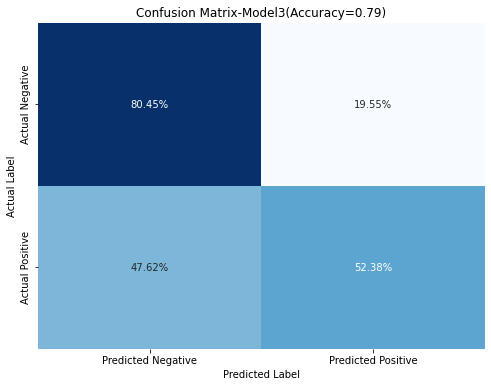

                 Predicted Negative  Predicted Positive
Actual Negative                 971                 236
Actual Positive                  30                  33
Precision: 0.12267657992565056 recall: 0.5238095238095238


In [566]:
cm = confusion_matrix(y_test, y_pred_3)
class_totals = cm.sum(axis=1, keepdims=True)

normalized_cm = cm / class_totals

df_confusion_matrix = pd.DataFrame(normalized_cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='.2%', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix-Model3(Accuracy={:.2f})'.format(model3.score(X_test_ms_std,y_test)))
plt.show()
df_cm = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'], columns=['Predicted Negative','Predicted Positive'])
print(df_cm)

true_positive = df_cm.at['Actual Positive', 'Predicted Positive']
false_positive = df_cm.at['Actual Negative', 'Predicted Positive']
false_negative = df_cm.at['Actual Positive', 'Predicted Negative']

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print('Precision:',precision,'recall:',recall)

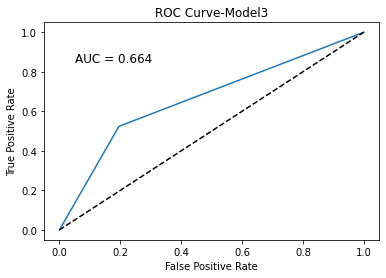

auc: 0.6641417130232374


In [567]:
##画出ROC曲线
y_scores_3 = model3.decision_function(X_test_ms_std)
y_true_binary = label_binarize(y_test, classes=[0, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_3)
auc_model3 = roc_auc_score(y_test, y_pred_3)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.text(0.05, 0.9, 'AUC = {:.3f}'.format(auc_model3), fontsize=12,va='top')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-Model3')
plt.show()
##计算AUC
auc_lr = roc_auc_score(y_test, y_pred_3)
print('auc:',auc_lr)

In [1032]:
features = X_train_ms.columns
coefficients = model3.coef_
intercept = model3.intercept_
for feature, coef in zip(features, coefficients[0]):
    print(f"Feature: {feature}, Coefficient: {coef}")

Feature: Customer_Age_inmonths, Coefficient: 0.14284357093231081
Feature: CHI_M0, Coefficient: -0.28817766396793904
Feature: CHI_M01, Coefficient: -0.2796429105603309
Feature: Support_M0, Coefficient: -0.1785029368816415
Feature: Support_M01, Coefficient: 0.24765344459318808
Feature: SP_M0, Coefficient: -0.0398345984634312
Feature: SP_M01, Coefficient: -0.0207358698271006
Feature: DaysLastLogin_M01, Coefficient: 0.23787031268698242


## 随机森林模型(实验，可忽略)

In [327]:
weights={0:1,1:30}
rfclf = RandomForestClassifier(n_estimators=10,max_depth=100,random_state=42)
rfclf.fit(X_train_smote,y_train_smote)
y_pred_rf = rfclf.predict(X_test)

In [328]:
accuracy_score(y_test,y_pred_rf)

0.9007874015748032

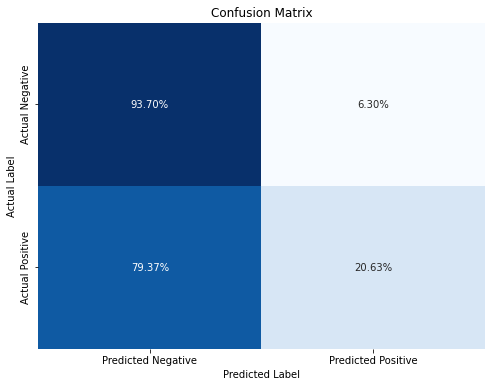

                 Predicted Negative  Predicted Positive
Actual Negative                1131                  76
Actual Positive                  50                  13
Precision: 0.14606741573033707 recall: 0.20634920634920634


In [329]:
cm = confusion_matrix(y_test, y_pred_rf)
class_totals = cm.sum(axis=1, keepdims=True)


normalized_cm = cm / class_totals


df_confusion_matrix = pd.DataFrame(normalized_cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])


plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='.2%', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
df_cm = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'], columns=['Predicted Negative','Predicted Positive'])
print(df_cm)


true_positive = df_cm.at['Actual Positive', 'Predicted Positive']
false_positive = df_cm.at['Actual Negative', 'Predicted Positive']
false_negative = df_cm.at['Actual Positive', 'Predicted Negative']

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print('Precision:',precision,'recall:',recall)

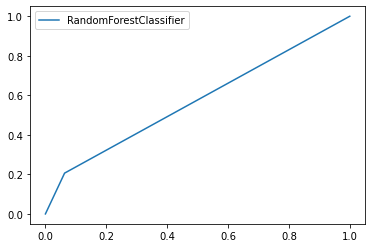

auc: 0.5716915874330952


In [330]:
auc_rf = roc_auc_score(y_test,y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
plt.plot(fpr, tpr,label='RandomForestClassifier')
plt.legend()
plt.show()
print('auc:',auc_rf)


## Deep Learning Models

#### 实验，请无视，跳至target model tuning

In [209]:
X_train = train.drop('Churn', axis=1)
y_train = train['Churn']

In [212]:
X_train_std,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [1139]:
X_train_ms = train.drop(['Churn','Blog_M01','SP_M01','Logins_M01'],axis=1)
y_train = train['Churn']
X_test_ms = test.drop(['Churn','Blog_M01','SP_M01','Logins_M01'],axis=1)
y_test = test['Churn']

##other experiments
#X_train_ms = train.drop(['Churn','Blog_M01','SP_M0','SP_M01','Logins_M01'],axis=1)
#X_test_ms = test.drop(['Churn','Blog_M01','SP_M0','SP_M01','Logins_M01'],axis=1)

sc = StandardScaler()
sc.fit(X_train_ms)
X_train_ms_std = sc.transform(X_train_ms)
X_test_ms_std = sc.transform(X_test_ms)

In [213]:
model_nn = tf.keras.Sequential()

model_nn.add(tf.keras.layers.Dense(128, activation='relu')) 
model_nn.add(tf.keras.layers.Dense(64, activation='relu'))  
model_nn.add(tf.keras.layers.Dropout(0.2))
model_nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


##OPTION1:class weights
class_weight = {0: 1, 1: 25}


model_nn.compile(optimizer=optimizer,  
              loss='binary_crossentropy',
              metrics=['binary_accuracy'],
              
              
              )
trainn = model_nn.fit(X_train_std, y_train,
                      class_weight = class_weight,
                      epochs=50,
                      validation_data=(X_val, y_val)
                      )


Epoch 1/50
102/102 [==============================] - 1s 4ms/step - loss: 38.0785 - binary_accuracy: 0.5507 - val_loss: 4.9554 - val_binary_accuracy: 0.3781
Epoch 2/50
102/102 [==============================] - 0s 2ms/step - loss: 18.3269 - binary_accuracy: 0.4706 - val_loss: 19.9313 - val_binary_accuracy: 0.5813
Epoch 3/50
102/102 [==============================] - 0s 2ms/step - loss: 20.5826 - binary_accuracy: 0.5119 - val_loss: 4.8025 - val_binary_accuracy: 0.4717
Epoch 4/50
102/102 [==============================] - 0s 2ms/step - loss: 15.1672 - binary_accuracy: 0.5541 - val_loss: 8.3891 - val_binary_accuracy: 0.2512
Epoch 5/50
102/102 [==============================] - 0s 2ms/step - loss: 8.9977 - binary_accuracy: 0.5458 - val_loss: 6.8721 - val_binary_accuracy: 0.3744
Epoch 6/50
102/102 [==============================] - 0s 3ms/step - loss: 11.8914 - binary_accuracy: 0.5553 - val_loss: 10.3885 - val_binary_accuracy: 0.1970
Epoch 7/50
102/102 [==============================] - 0s 

In [214]:
loss, accuracy = model_nn.evaluate(X_test_std, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
y_pred_nn = np.round(model_nn.predict(X_test_std))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nn)
auc = roc_auc_score(y_test, y_pred_nn)
print('AUC:',auc)
print('F1-score:',f1_score(y_pred_nn,y_test))

40/40 [==============================] - 0s 1ms/step - loss: 0.2390 - binary_accuracy: 0.9504
Test Loss: 0.23902378976345062
Test Accuracy: 0.9503936767578125
40/40 [==============================] - 0s 922us/step
AUC: 0.5
F1-score: 0.0


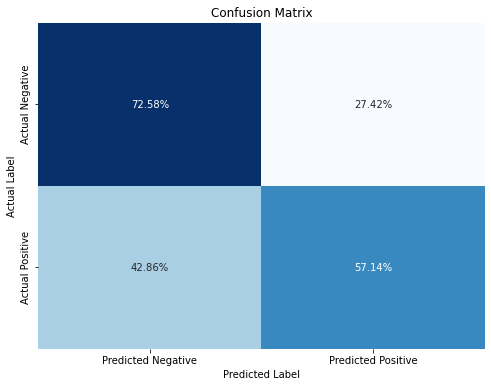

In [153]:
cm = confusion_matrix(y_test, y_pred_nn)
class_totals = cm.sum(axis=1, keepdims=True)

# 归一化混淆矩阵
normalized_cm = cm / class_totals

# 创建混淆矩阵的数据框
df_confusion_matrix = pd.DataFrame(normalized_cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

# 绘制彩色图像
plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='.2%', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

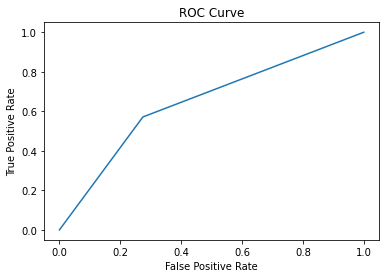

In [154]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nn)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## target model tuning and recording

In [353]:
##创建一个列表来记录不同weight下accuracy和recall的数值
record = pd.DataFrame(columns=['weight', 'accuracy', 'recall'])

In [569]:
#初始化训练数据
X_train = train.drop(['Churn'],axis=1)
y_train = train['Churn']
X_test = test.drop(['Churn'],axis=1)
y_test = test['Churn']

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [570]:
X_train_std,X_val,y_train,y_val = train_test_split(X_train_std,y_train,test_size=0.2,random_state=42)

In [577]:
#
model_nn2 = tf.keras.Sequential()
model_nn2.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))
model_nn2.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))  # 第二层添加L2正则化
#model_nn2.add(tf.keras.layers.Dropout(0.1))
model_nn2.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))  # 第三层添加L2正则化
#model_nn2.add(tf.keras.layers.Dropout(0.1))
model_nn2.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))  # 第三层添加L2正则化
model_nn2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

'''def weighted_loss(y_test, y_pred):
    y_test = tf.cast(y_test, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_test, logits = y_pred, pos_weight=20
                                                    )
    return tf.reduce_mean(loss)
    '''
weight = 35
class_weight = {0: 1, 1:weight}

model_nn2.compile(optimizer=optimizer,  
              metrics=['binary_accuracy'],
              loss='binary_crossentropy'
              )
# 添加提前停止回调函数
early_stopping = tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True)

trainn = model_nn2.fit(X_train_std, y_train,
                       epochs=120,
                       validation_data=(X_val, y_val),
                       callbacks=[early_stopping],
                       class_weight = class_weight)

loss, accuracy = model_nn2.evaluate(X_test_std,y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
y_pred_nn2 = np.round(model_nn2.predict(X_test_std))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nn2)
auc = roc_auc_score(y_test, y_pred_nn2)
print('auc:',auc)
print('recall',recall_score(y_test, y_pred_nn2))

Epoch 1/120
127/127 [==============================] - 2s 4ms/step - loss: 4.7862 - binary_accuracy: 0.1830 - val_loss: 2.0682 - val_binary_accuracy: 0.0522
Epoch 2/120
127/127 [==============================] - 0s 2ms/step - loss: 2.3316 - binary_accuracy: 0.2061 - val_loss: 1.4162 - val_binary_accuracy: 0.3071
Epoch 3/120
127/127 [==============================] - 0s 2ms/step - loss: 1.9051 - binary_accuracy: 0.3068 - val_loss: 1.0904 - val_binary_accuracy: 0.4862
Epoch 4/120
127/127 [==============================] - 0s 2ms/step - loss: 1.7833 - binary_accuracy: 0.4361 - val_loss: 1.1249 - val_binary_accuracy: 0.1870
Epoch 5/120
127/127 [==============================] - 0s 2ms/step - loss: 1.7331 - binary_accuracy: 0.4299 - val_loss: 1.3813 - val_binary_accuracy: 0.1575
Epoch 6/120
127/127 [==============================] - 0s 2ms/step - loss: 1.7230 - binary_accuracy: 0.3632 - val_loss: 1.0784 - val_binary_accuracy: 0.4203
Epoch 7/120
127/127 [==============================] - 0s 

In [443]:
new_data = {'weight': weight , 'accuracy': accuracy, 'recall': recall_score(y_test, y_pred_nn2)}
record = record.append(new_data, ignore_index=True)

/var/folders/b9/zr3r6bvd7ss0rlkk_zdm2wm40000gn/T/ipykernel_13749/107439946.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record = record.append(new_data, ignore_index=True)


In [ ]:
model_nn2.save('model_nn_best.h5')

In [44]:
record = record.sort_values('weight', ascending=True)
record.to_csv('record.csv', index=False)

In [45]:
record = pd.read_csv('./record.csv')
record

,weight,accuracy,recall
0,1.0,0.950394,0.000000
1,5.0,0.950394,0.000000
2,10.0,0.918110,0.269841
3,15.0,0.869291,0.349206
4,20.0,0.785827,0.460317
5,25.0,0.742520,0.555556
6,30.0,0.701575,0.634921
7,35.0,0.648031,0.698413
8,40.0,0.554331,0.873016
9,45.0,0.548032,0.825397


## 此处展示实验中最优模型的结果

In [31]:
model_best = keras.models.load_model('model_nn_best.h5')

In [585]:


loss, accuracy = model_best.evaluate(X_test_std,y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
y_pred_best = np.round(model_best.predict(X_test_std))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_pred_best)
print('auc:',auc)
print('recall',recall_score(y_test, y_pred_best))

40/40 [==============================] - 0s 1ms/step - loss: 0.8714 - binary_accuracy: 0.5512
Test Loss: 0.8714298605918884
Test Accuracy: 0.5511810779571533
40/40 [==============================] - 0s 1ms/step
auc: 0.7112215778330111
recall 0.8888888888888888


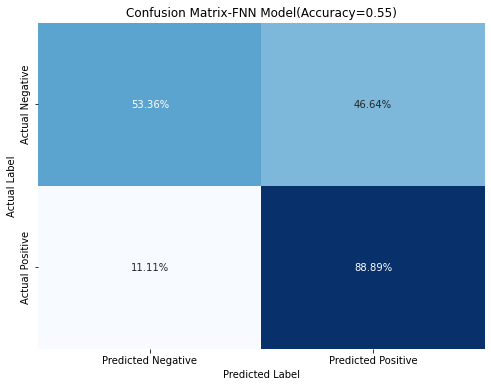

In [583]:
cm = confusion_matrix(y_test, y_pred_best)
class_totals = cm.sum(axis=1, keepdims=True)

normalized_cm = cm / class_totals

df_confusion_matrix = pd.DataFrame(normalized_cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])


plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='.2%', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix-FNN Model(Accuracy={:.2f})'.format(accuracy))
plt.show()

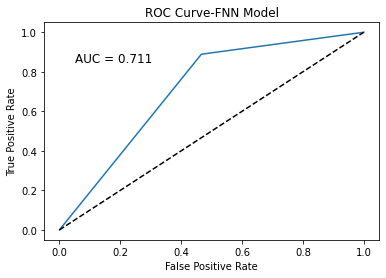

In [586]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_best)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.text(0.05, 0.9, 'AUC = {:.3f}'.format(auc_best), fontsize=12,va='top')
plt.title('ROC Curve-FNN Model')
plt.show()

In [413]:
##auc rate is higher than 0.7

#### 未采用

In [246]:
### 第二次尝试，model3：批归一化+early stopping,未采用
X_train = train.drop(['Churn'],axis=1)
y_train = train['Churn']
X_test = test.drop(['Churn'],axis=1)
y_test = test['Churn']
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

model_nn3 = tf.keras.Sequential()

model_nn3.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03)))  
model_nn3.add(tf.keras.layers.BatchNormalization())  
#model_nn3.add(tf.keras.layers.Dropout(0.2))
model_nn3.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03))) 
model_nn3.add(tf.keras.layers.BatchNormalization())  
#model_nn3.add(tf.keras.layers.Dropout(0.2))
model_nn3.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03))) 
model_nn2.add(tf.keras.layers.BatchNormalization())  
model_nn3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


class_weight = {0: 1, 1:12.5}

model_nn3.compile(optimizer=optimizer,  
              metrics=['binary_accuracy'],
              loss='binary_crossentropy'
              )
early_stopping = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

# 训练模型
trainn = model_nn3.fit(X_train, y_train,
                       epochs=50,
                       validation_data=(X_val, y_val),
                       callbacks=[early_stopping],
                       class_weight = class_weight)

loss, accuracy = model_nn3.evaluate(X_test_std,y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
y_pred_nn3 = np.round(model_nn3.predict(X_test_std))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nn3)
auc = roc_auc_score(y_test, y_pred_nn3)
print('auc:',auc)

Epoch 1/50
127/127 [==============================] - 2s 5ms/step - loss: 4.2057 - binary_accuracy: 0.8272 - val_loss: 2.9008 - val_binary_accuracy: 0.8217
Epoch 2/50
127/127 [==============================] - 0s 4ms/step - loss: 2.7991 - binary_accuracy: 0.8040 - val_loss: 2.0843 - val_binary_accuracy: 0.7596
Epoch 3/50
127/127 [==============================] - 0s 3ms/step - loss: 2.1751 - binary_accuracy: 0.8040 - val_loss: 1.5776 - val_binary_accuracy: 0.8305
Epoch 4/50
127/127 [==============================] - 0s 3ms/step - loss: 1.8171 - binary_accuracy: 0.8255 - val_loss: 1.3014 - val_binary_accuracy: 0.8236
Epoch 5/50
127/127 [==============================] - 0s 3ms/step - loss: 1.5906 - binary_accuracy: 0.7989 - val_loss: 1.1576 - val_binary_accuracy: 0.7409
Epoch 6/50
127/127 [==============================] - 0s 2ms/step - loss: 1.4292 - binary_accuracy: 0.8174 - val_loss: 0.9933 - val_binary_accuracy: 0.8010
Epoch 7/50
127/127 [==============================] - 0s 2ms/ste

In [247]:
loss, accuracy = model_nn3.evaluate(X_test_std,y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
y_pred_nn3 = np.round(model_nn3.predict(X_test_std))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nn3)
auc = roc_auc_score(y_test, y_pred_nn3)
print('auc:',auc)

40/40 [==============================] - 0s 1ms/step - loss: 0.9212 - binary_accuracy: 0.0496
Test Loss: 0.9211769104003906
Test Accuracy: 0.04960630089044571
40/40 [==============================] - 0s 2ms/step
auc: 0.5


## 降维后数据的分析(实验，可忽略)

#### 1.确定主成分个数并获取降维后数据：

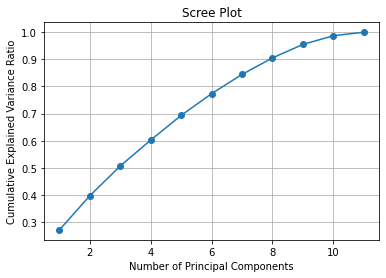

In [1004]:
pca = PCA()
pca.fit(X_train_std)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

##### 选择n=6

In [1063]:
pca = PCA(n_components=8).fit(X_train_std)
X_train_std_pca = pca.transform(X_train_std)
X_test_std_pca = pca.transform(X_test_std)

In [1064]:
model2p =LogisticRegression(class_weight=weights)
model2p.fit(X_train_std_pca,y_train)
y_pred_2p = model2p.predict(X_test_std_pca)
print('overall accuracy:',model2p.score(X_test_std_pca,y_test))


overall accuracy: 0.7251968503937007


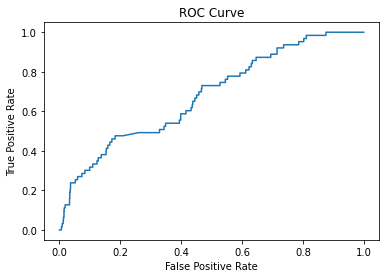

auc: 0.6147144303730881


In [1065]:
y_scores_2p = model2p.decision_function(X_test_std_pca)
y_true_binary = label_binarize(y_test, classes=[0, 1])
fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores_2p)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
##计算AUC
auc = roc_auc_score(y_test, y_pred_2p)
print('auc:',auc)

In [90]:
model_nnp = tf.keras.Sequential()

model_nnp.add(tf.keras.layers.Dense(128, activation='relu'))  
model_nnp.add(tf.keras.layers.Dense(64, activation='relu'))
model_nnp.add(tf.keras.layers.Dropout(0.2))
model_nnp.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


##OPTION1:class weights
#class_weight = {0: 1, 1: 35}


model_nnp.compile(optimizer=optimizer,  
              loss='binary_crossentropy',
              metrics=['binary_accuracy'],
              
              
              )
# 训练模型---输入参数
trainn = model_nnp.fit(X_train_smote, y_train,
                      epochs=50
                      )

Epoch 1/50
302/302 [==============================] - 3s 2ms/step - loss: 4.7052 - binary_accuracy: 0.5967
Epoch 2/50
302/302 [==============================] - 1s 2ms/step - loss: 1.5164 - binary_accuracy: 0.6450
Epoch 3/50
302/302 [==============================] - 1s 2ms/step - loss: 0.8031 - binary_accuracy: 0.6645
Epoch 4/50
302/302 [==============================] - 0s 2ms/step - loss: 0.6142 - binary_accuracy: 0.6699
Epoch 5/50
302/302 [==============================] - 1s 2ms/step - loss: 0.5756 - binary_accuracy: 0.6873
Epoch 6/50
302/302 [==============================] - 1s 2ms/step - loss: 0.5632 - binary_accuracy: 0.6944
Epoch 7/50
302/302 [==============================] - 1s 2ms/step - loss: 0.5483 - binary_accuracy: 0.7084
Epoch 8/50
302/302 [==============================] - 1s 2ms/step - loss: 0.5489 - binary_accuracy: 0.7111
Epoch 9/50
302/302 [==============================] - 1s 2ms/step - loss: 0.5374 - binary_accuracy: 0.7189
Epoch 10/50
302/302 [================

In [97]:
loss, accuracy = model_nnp.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
y_pred_nnp = np.round(model_nnp.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nnp)
auc = roc_auc_score(y_test, y_pred_nnp)
print('auc:',auc)

40/40 [==============================] - 0s 2ms/step - loss: 0.6484 - binary_accuracy: 0.7268
Test Loss: 0.6483562588691711
Test Accuracy: 0.7267716526985168
40/40 [==============================] - 0s 1ms/step
auc: 0.5854538998698071


结果不如人意。。。。

# 最终结果

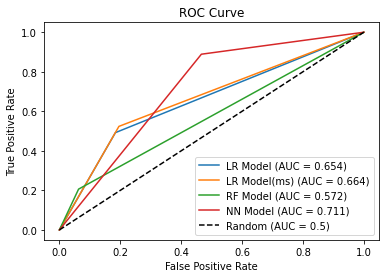

In [588]:
fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_2)
fpr_2, tpr_2, _ = roc_curve(y_test, y_pred_3)
fpr_3, tpr_3, _ = roc_curve(y_test, y_pred_rf)
fpr_4, tpr_4, _ = roc_curve(y_test, y_pred_best)

# 计算每个模型的 AUC
auc_1 = roc_auc_score(y_test, y_pred_2)
auc_2 = roc_auc_score(y_test, y_pred_3)
auc_3 = roc_auc_score(y_test, y_pred_rf)
auc_4 = roc_auc_score(y_test, y_pred_best)

# 绘制 ROC 曲线
plt.plot(fpr_1, tpr_1, label='LR Model (AUC = {:.3f})'.format(auc_1))
plt.plot(fpr_2, tpr_2, label='LR Model(ms) (AUC = {:.3f})'.format(auc_2))
plt.plot(fpr_3, tpr_3, label='RF Model (AUC = {:.3f})'.format(auc_3))
plt.plot(fpr_4, tpr_4, label='NN Model (AUC = {:.3f})'.format(auc_4))
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.show()

In [32]:
explainer = shap.Explainer(model_best, X_train_std)

#### acc与recall随weight变化图

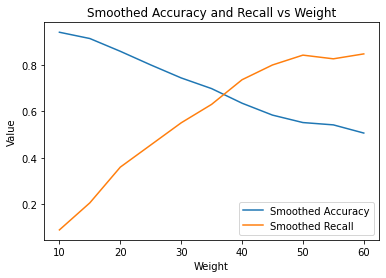

In [46]:

window_size = 3

smoothed_accuracy = np.convolve(record['accuracy'], np.ones(window_size)/window_size, mode='valid')
smoothed_recall = np.convolve(record['recall'], np.ones(window_size)/window_size, mode='valid')

plt.plot(record['weight'][window_size-1:], smoothed_accuracy, label='Smoothed Accuracy')

plt.plot(record['weight'][window_size-1:], smoothed_recall, label='Smoothed Recall')

plt.legend()

plt.title('Smoothed Accuracy and Recall vs Weight')
plt.xlabel('Weight')
plt.ylabel('Value')

plt.show()


In [51]:
np.array(1-record['accuracy'])+0.4*np.array(1-record['recall'])

array([0.449606 , 0.449606 , 0.3739536, 0.3910266, 0.4300462, 0.4352576,
       0.4444566, 0.4726038, 0.4964626, 0.5218092, 0.5178722, 0.5454322,
       0.6019244])

#### 单个案例解释-SHAP

Permutation explainer: 1271it [02:55,  6.83it/s]                                


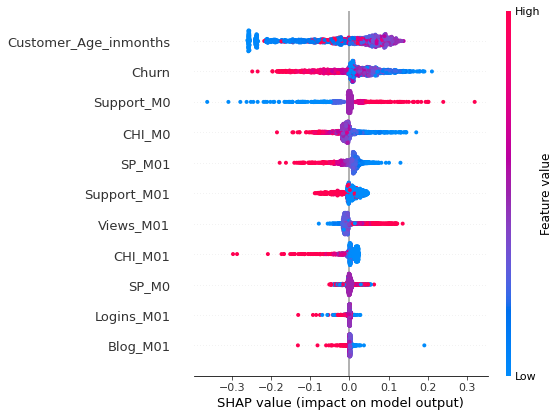

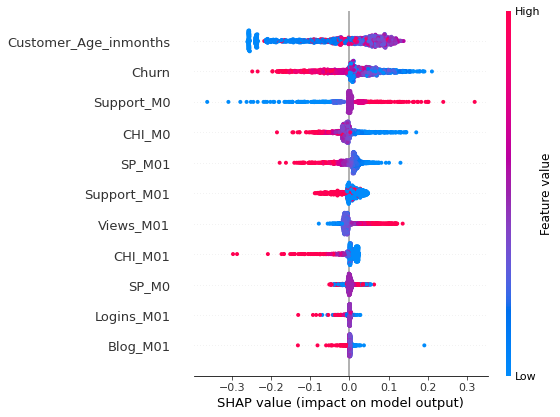

In [35]:


# 解释单个样本的预测结果
shap_values = explainer(X_test_std)

# 绘制SHAP值的条形图
shap.summary_plot(shap_values, X_test_std, feature_names=train.columns)

# 绘制每个特征的SHAP值散点图
shap.summary_plot(shap_values, X_test_std, feature_names=train.columns, plot_type="dot")


In [119]:
features

Index(['Customer_Age_inmonths', 'CHI_M0', 'CHI_M01', 'Support_M0',
       'Support_M01', 'SP_M0', 'SP_M01', 'Logins_M01', 'Blog_M01', 'Views_M01',
       'DaysLastLogin_M01'],
      dtype='object')

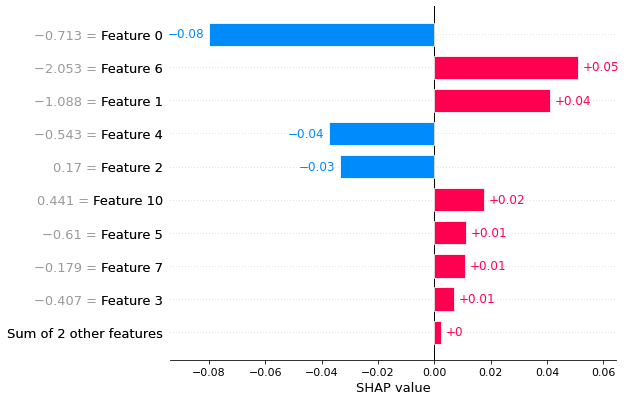

In [129]:
shap.plots.bar(shap_values[43],show_data=True)

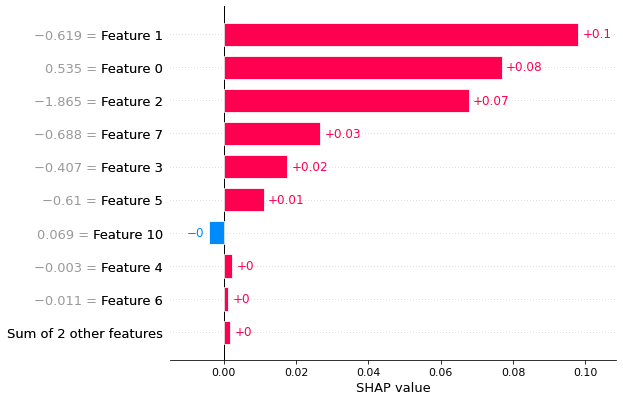

In [126]:
shap.plots.bar(shap_values[74],show_data=True)

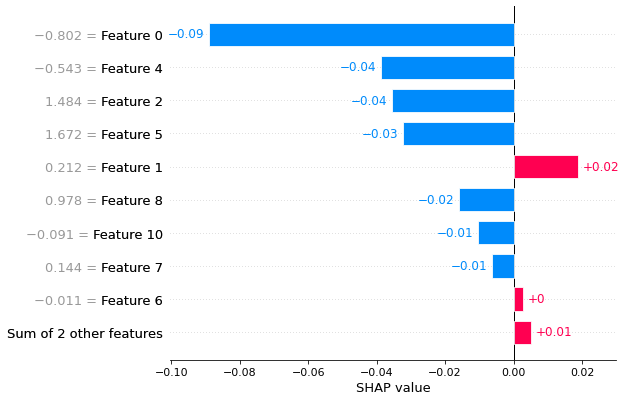

In [133]:
shap.plots.bar(shap_values[17],show_data=True)

In [132]:
train.head(10)

,Customer_Age_inmonths,Churn,CHI_M0,CHI_M01,Support_M0,Support_M01,SP_M0,SP_M01,Logins_M01,Blog_M01,Views_M01,DaysLastLogin_M01
0,9,0,107,57,1,1,3.0,3.0,89,0,0,0
1,6,0,18,-3,0,0,0.0,0.0,-2,0,0,-13
2,36,0,155,0,0,-2,0.0,-2.5,-29,0,-930,0
3,5,0,2,-8,1,0,3.0,0.0,-16,0,9,0
4,13,0,76,-38,0,-1,0.0,-3.0,-11,-2,-5,5
5,34,0,95,0,0,0,0.0,0.0,0,0,-213,31
6,20,0,137,-5,0,-3,0.0,-3.0,-15,0,707,0
7,15,0,25,25,0,0,0.0,0.0,6,0,0,31
8,27,0,205,-1,1,1,3.0,3.0,-8,-1,1167,0
9,6,0,11,-59,0,-6,0.0,-3.0,-28,0,2,0


In [134]:
lost

,Customer_Age_inmonths,Churn,CHI_M0,CHI_M01,Support_M0,Support_M01,SP_M0,SP_M01,Logins_M01,Blog_M01,Views_M01,DaysLastLogin_M01
29,21,1,5,5,0,0,0.0,0.0,2,0,-1,30
43,6,1,159,0,1,1,3.0,3.0,57,1,5664,0
48,12,1,0,0,0,0,0.0,0.0,0,0,0,30
52,27,1,0,0,0,0,0.0,0.0,0,0,0,31
74,36,1,5,0,0,0,0.0,0.0,0,0,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...
4989,15,1,129,45,0,0,0.0,0.0,62,1,501,0
4999,31,1,95,23,0,0,0.0,0.0,0,0,3,31
5039,31,1,105,1,0,-1,0.0,-3.0,-17,0,-1382,-4
5055,20,1,170,46,0,0,0.0,0.0,17,1,-2005,3
